# Signal Detection: Exam 2023 problem

This problem is about separating signal from noise using two variables (Phase & Resonance), fitting a frequency signal peak in a large control sample (Hydrogen at 1.42 GHz) in the cleaned data, and searching for a signal peak in the smaller real sample (Deuterium at 0.327 GHz).

Inspired by: https://iopscience.iop.org/article/10.1086/511978/meta


### Problems:

The file "data_SignalDetection.csv" contains 120000 entries with values of P, R, frequency, and type.
In the first 100000 entries (control sample) it is known if entries are signal (1) or background (0).
In the last 20000 entries (real sample) this is unknown.

1. Plot the control sample frequency distribution. Fit the observed H-peak at $\nu = 1.42~\mbox{GHz}$.
2. Quantify how well you can separate signal from noise using the variables $P$ and $R$.
3. Selecting entries based only on $P$ and $R$, how significant can you get the H-peak fit to be?
4. Plot the real data frequency distribution, and search for a peak in the range [0.1,1.0] GHz.
5. How many signal entries do you estimate there to be in the peak? Do you find it significant?
6. Correcting for the signal selection efficiency when using $P$ and $R$, how many signal entries
      do you estimate there was in the data originally?

Internal comments:
- Give away the simple cut R-P > 0?

---

##  Author: 
- Troels Petersen ([email](mailto:petersen@nbi.dk))

##  Date:   
17th of January 2024 (latest version)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats

In [2]:
r = np.random             # Random generator
r.seed(41)                # Set a random (but fixed) seed

In [3]:
Verbose = False
Saveplots = False
plt.rcParams.update({'font.size': 18})
font_size = 10

---
## Producing the data:


In [4]:
# Size of samples:
Ncontrol = 100000
fsig_control = 0.02
Nreal = 20000
fsig_real = 0.010
fsig_poor = 0.15     # Fraction of signal that has poor resolution and (possibly) a bias

# Rotation of produced x and y values:
theta = 0.9

# Signal frequency width:
w_sig = 0.025

In [5]:
# Produce CONTROL sample:
Nsig_control = int(Ncontrol * fsig_control)
Nsig_control_poor = int(Nsig_control * fsig_poor)
Nsig_control_good = Nsig_control - Nsig_control_poor
Nbkg_control = Ncontrol - Nsig_control

# Signal events:
x_sig = np.random.normal(7.1, 5.1, Nsig_control)
y_sig = 1.1*np.sin(x_sig/0.65+2.5) + np.random.normal(1.7, 1.4, Nsig_control)
P_sig = np.cos(theta)*x_sig - np.sin(theta)*y_sig
R_sig = np.sin(theta)*x_sig + np.cos(theta)*y_sig
freq1_sig = np.random.normal(1.420, w_sig, Nsig_control_good)
freq2_sig = np.random.normal(1.420+0.031, 3.5*w_sig, Nsig_control_poor)
freq_sig = np.concatenate((freq1_sig, freq2_sig), axis=0)
data_sig = np.c_[P_sig, R_sig, freq_sig, np.ones(Nsig_control, dtype=np.int32)]

# Background/noise events:
x_bkg = np.random.normal(6.5, 4.5, Nbkg_control)
y_bkg = 0.9*np.sin(x_bkg/0.65+2.5) - np.random.normal(1.9, 1.7, Nbkg_control)
P_bkg = np.cos(theta)*x_bkg - np.sin(theta)*y_bkg
R_bkg = np.sin(theta)*x_bkg + np.cos(theta)*y_bkg
# fre_bkg = np.random.lognormal(0.09, 1.427, Nbkg_control)      # Gives a problematic peak around lower peak!
freq_bkg = np.random.exponential(1.427, Nbkg_control)
data_bkg = np.c_[P_bkg, R_bkg, freq_bkg, np.zeros(Nbkg_control, dtype=np.int32)]

# Combine the signal and background, and randomise it:
data_control = np.concatenate((data_sig, data_bkg), axis=0)
np.random.shuffle(data_control)

In [6]:
# Produce REAL sample:
Nsig_real = int(Nreal * fsig_real)
Nsig_real_poor = int(Nsig_real * fsig_poor)
Nsig_real_good = Nsig_real - Nsig_real_poor
Nbkg_real = Nreal - Nsig_real

# Signal events:
x_sig = np.random.normal(7.1, 5.1, Nsig_real)
y_sig = 1.1*np.sin(x_sig/0.65+2.5) + np.random.normal(1.7, 1.4, Nsig_real)
P_sig = np.cos(theta)*x_sig - np.sin(theta)*y_sig
R_sig = np.sin(theta)*x_sig + np.cos(theta)*y_sig
freq1_sig = np.random.normal(0.327, w_sig, Nsig_real_good)
freq2_sig = np.random.normal(0.327+0.031, 3.5*w_sig, Nsig_real_poor)
freq_sig = np.concatenate((freq1_sig, freq2_sig), axis=0)
data_sig = np.c_[P_sig, R_sig, freq_sig, -1*np.ones(Nsig_real, dtype=np.int32)]

# Background/noise events:
x_bkg = np.random.normal(6.5, 4.5, Nbkg_real)
y_bkg = 0.9*np.sin(x_bkg/0.65+2.5) - np.random.normal(1.9, 1.7, Nbkg_real)
P_bkg = np.cos(theta)*x_bkg - np.sin(theta)*y_bkg
R_bkg = np.sin(theta)*x_bkg + np.cos(theta)*y_bkg
# fre_bkg = np.random.lognormal(0.09, 1.427, Nbkg_real)
freq_bkg = np.random.exponential(1.427, Nbkg_real)
data_bkg = np.c_[P_bkg, R_bkg, freq_bkg, -1*np.ones(Nbkg_real, dtype=np.int32)]

# Combine the signal and background, and randomise it:
data_real = np.concatenate((data_sig, data_bkg), axis=0)
np.random.shuffle(data_real)

In [7]:
# Produce the final combined sample:
data_combined = np.concatenate((data_control, data_real), axis=0)
data_final = np.c_[np.arange(1,len(data_combined)+1), data_combined]

# Print a small range in each of the data regions:
#print(data_final[500:508])
#print(data_final[10500:10508])

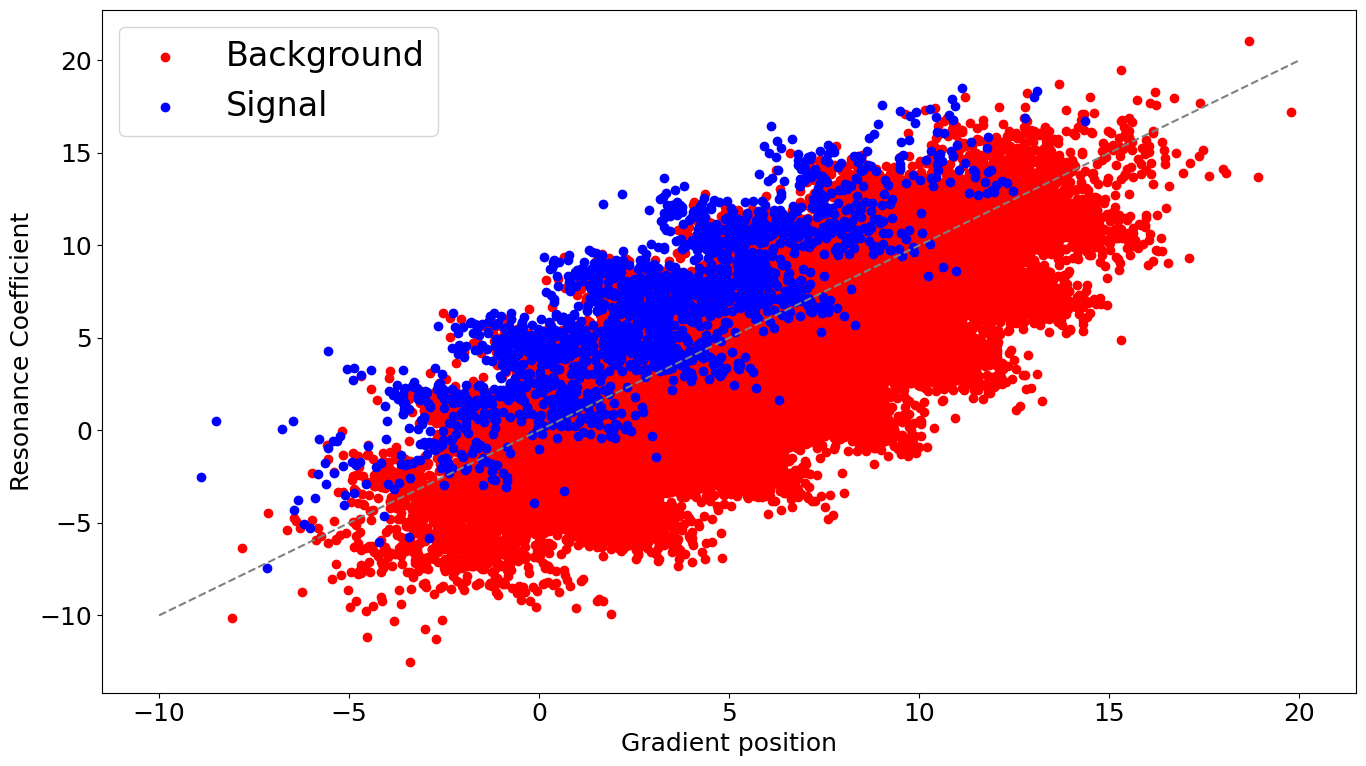

In [8]:
# Plot the separation variables
fig_2D, ax_2D = plt.subplots(figsize=(14, 8))

ax_2D.scatter(data_final[:,1][data_final[:,4]==0], data_final[:,2][data_final[:,4]==0], color='red', label="Background")
ax_2D.scatter(data_final[:,1][data_final[:,4]==1], data_final[:,2][data_final[:,4]==1], color='blue', label="Signal")
ax_2D.plot((-10,20), (-10,20), c='gray', ls="--")

ax_2D.set(xlabel='Gradient position', ylabel='Resonance Coefficient')
ax_2D.legend(loc='upper left', fontsize=24)

fig_2D.tight_layout()
fig_2D.savefig('InputVars_2D.pdf', dpi=600)

---

### Write data to file, and re-read file:

In [9]:
np.savetxt("data_SignalDetection.csv", data_final, delimiter=",", fmt='%10.5f', header="  Index,     Phase,    Resonance, Frequency,   Type", comments='')

In [10]:
data = np.genfromtxt('data_SignalDetection.csv', delimiter=',', dtype=float, skip_header=1)
print(data)

[[ 1.000000e+00  6.417480e+00  1.359860e+00  2.293550e+00  0.000000e+00]
 [ 2.000000e+00  2.832970e+00  2.881360e+00  9.573200e-01  0.000000e+00]
 [ 3.000000e+00  5.130040e+00  1.145223e+01  1.419310e+00  1.000000e+00]
 ...
 [ 1.199980e+05  5.323800e-01 -2.072950e+00  4.050400e-01 -1.000000e+00]
 [ 1.199990e+05  1.943280e+00  8.690950e+00  4.300000e-04 -1.000000e+00]
 [ 1.200000e+05  2.350500e+00  1.200620e+00  7.069240e+00 -1.000000e+00]]


***

### Plot the data:

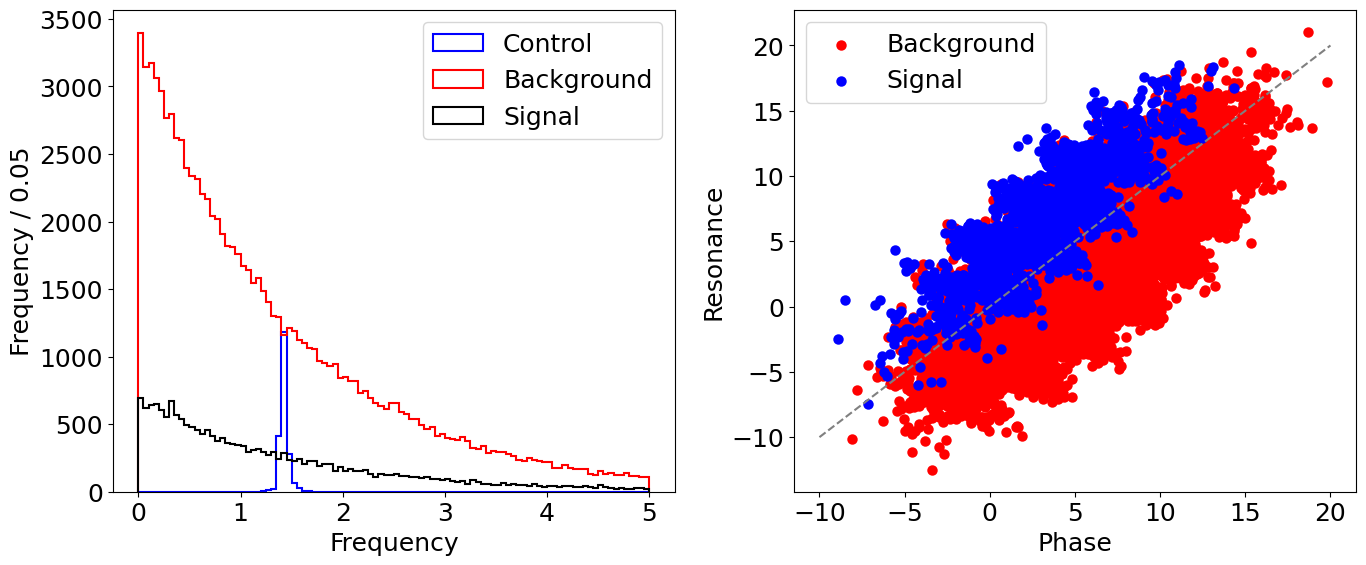

In [11]:
fig_1D, ax_1D = plt.subplots(ncols=2, figsize=(14, 6))

ax_1D[0].hist(data[:,3][data[:,4]==1], 100, (0, 5), histtype='step', label='Control', color='Blue', lw=1.5)
ax_1D[0].hist(data[:,3][data[:,4]==0], 100, (0, 5), histtype='step', label='Background', color='Red', lw=1.5)
ax_1D[0].hist(data[:,3][data[:,4]==-1], 100, (0, 5), histtype='step', label='Signal', color='Black', lw=1.5)
ax_1D[0].set(title='', xlabel='Frequency', ylabel='Frequency / 0.05')
ax_1D[0].legend(loc='upper right')

ax_1D[1].scatter(data[:,1][data[:,4]==0], data[:,2][data[:,4]==0], label='Background', color='Red', lw=1.5)
ax_1D[1].scatter(data[:,1][data[:,4]==1], data[:,2][data[:,4]==1], label='Signal', color='Blue', lw=1.5)
ax_1D[1].plot((-10,20), (-10,20), c='gray', ls="--")
ax_1D[1].set(title='', xlabel='Phase', ylabel='Resonance')
ax_1D[1].legend(loc='upper left')

fig_1D.tight_layout()
fig_1D.savefig('InputVarsDist.pdf', dpi=600)

## Fitting signal peak:

In [12]:
def func_Gauss(x, Nsig, mu, sigma) :
    return Nsig * binwidth * stats.norm.pdf(x, mu, sigma)

def func_GaussGauss(x, Nsig, frac_core, mu1, sigma1, mu2, sigma2) :
    return Nsig * binwidth * (frac_core * stats.norm.pdf(x, mu1, sigma1) + (1.0-frac_core)*stats.norm.pdf(x, mu2, sigma2))

In [13]:
Nbins = 100
xmin, xmax = 1.0, 2.0
binwidth = (xmax-xmin)/Nbins

mask0_selection = (data[:,4]>0.5)
y, bin_edges = np.histogram(data[:, 3][mask0_selection], bins=Nbins, range=(xmin, xmax), density=False)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)

fit_chi2 = cost.LeastSquares(x[y>0], y[y>0], sy[y>0], func_Gauss)
minuit_chi2 = Minuit(fit_chi2, Nsig=1000.0, mu=1.42, sigma=0.015)
minuit_chi2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 140.7 (χ²/ndof = 3.3)      │              Nfcn = 74               │
│ EDM = 4.58e-07 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nsig  │  1.86e3   │  0.04e3   │            │            │         │         │       │
│ 1 │ mu    │  1.4215   │  0.0007   │            │            │         │         │       │
│ 2 │ sigma │  27.6e-3  │  0.5e-3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │     Nsig       mu    sigma │
├───────┼────────────────────────────┤
│  Nsig │ 1.86e+03  -4.8e-6 -4.36e-6 │
│    mu │  -4.8e-6 4.43e-07  0.10e-6 │
│ sigma │ -4.36e-6  0.10e-6 2.78e-07 │
└───────┴────────────────────────────┘

In [14]:
for name in minuit_chi2.parameters:
    print("Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_chi2.values[name], minuit_chi2.errors[name]))
    
Ndof = len(y[y>0])-len(minuit_chi2.values[:])
ProbChi2 = stats.chi2.sf(minuit_chi2.fval, Ndof)
print(f"  The fit p-value was: Prob(Chi2={minuit_chi2.fval:5.1f}, Ndof={Ndof:2d}) = {ProbChi2:6.4f}")

Fit result: Nsig = 1859.30561 +/- 43.11993
Fit result: mu = 1.42148 +/- 0.00067
Fit result: sigma = 0.02764 +/- 0.00053
  The fit p-value was: Prob(Chi2=140.7, Ndof=42) = 0.0000


In [15]:
fit_chi2b = cost.LeastSquares( x[y>0], y[y>0], sy[y>0], func_GaussGauss)
minuit_chi2b = Minuit(fit_chi2b, Nsig=6000.0, frac_core=0.9, mu1=1.42, sigma1=0.015, mu2=1.44, sigma2=0.04)
minuit_chi2b.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.93 (χ²/ndof = 0.9)      │              Nfcn = 258              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nsig      │  1.97e3   │  0.04e3   │            │            │         │         │       │
│ 1 │ frac_core │   0.851   │   0.018   │            │            │         │         │       │
│ 2 │ mu1       │  1.4202   │  0.0007   │            │            │         │         │       │
│ 3 │ sigma1    │  24.8e-3  │  0.6e-3   │            │            │         │         │       │
│ 4 │ mu2       │   1.460   │   0.007   │            │            │         │         │       │
│ 5 │ sigma2    │   0.078   │   0.006   │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────┐
│           │      Nsig frac_core       mu1    sigma1       mu2    sigma2 │
├───────────┼─────────────────────────────────────────────────────────────┤
│      Nsig │  1.97e+03   5.89e-3  220.6e-6  124.0e-6   0.96e-3   6.58e-3 │
│ frac_core │   5.89e-3  0.000316    2.5e-6    6.2e-6   0.05e-3   0.04e-3 │
│       mu1 │  220.6e-6    2.5e-6  5.52e-07    0.1e-6   -0.6e-6    1.5e-6 │
│    sigma1 │  124.0e-6    6.2e-6    0.1e-6  3.86e-07    1.4e-6    0.9e-6 │
│       mu2 │   0.96e-3   0.05e-3   -0.6e-6    1.4e-6  4.34e-05        -0 │
│    sigma2 │   6.58e-3   0.04e-3    1.5e-6    0.9e-6        -0  3.65e-05 │
└───────────┴─────────────────────────────────────────────────────────────┘

In [16]:
for name in minuit_chi2b.parameters:
    print("Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_chi2b.values[name], minuit_chi2b.errors[name]))
    
Ndof = len(y[y>0])-len(minuit_chi2b.values[:])
ProbChi2 = stats.chi2.sf(minuit_chi2b.fval, Ndof)
print(f"  The fit p-value was: Prob(Chi2={minuit_chi2b.fval:5.1f}, Ndof={Ndof:2d}) = {ProbChi2:6.4f}")

Fit result: Nsig = 1966.41400 +/- 44.38367
Fit result: frac_core = 0.85092 +/- 0.01778
Fit result: mu1 = 1.42020 +/- 0.00074
Fit result: sigma1 = 0.02480 +/- 0.00062
Fit result: mu2 = 1.46021 +/- 0.00659
Fit result: sigma2 = 0.07826 +/- 0.00604
  The fit p-value was: Prob(Chi2= 35.9, Ndof=39) = 0.6107


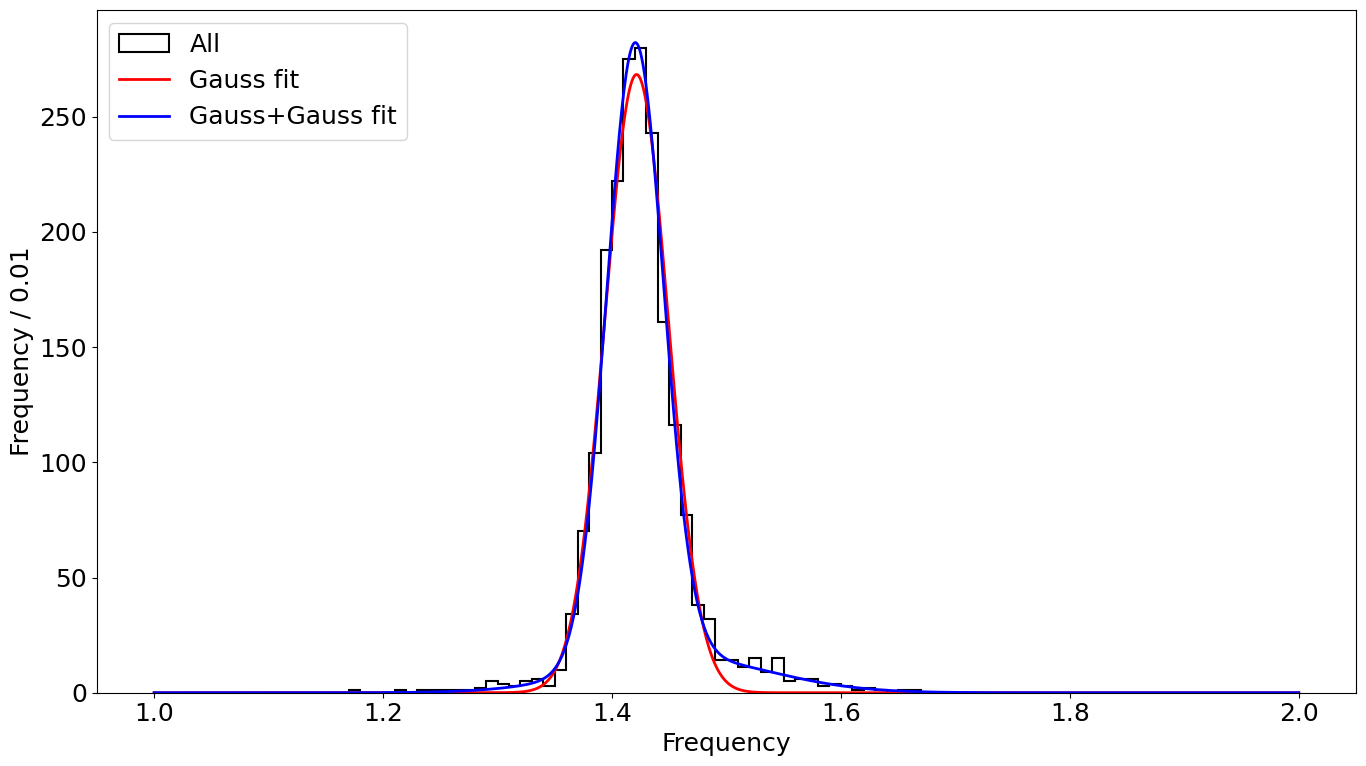

In [17]:
fig_truth, ax_truth = plt.subplots(ncols=1, figsize=(14, 8))

ax_truth.hist(data[:, 3][mask0_selection], 100, (1, 2), histtype='step', label='All', color='Black', lw=1.5)
ax_truth.set(title='', xlabel='Frequency', ylabel='Frequency / 0.01')

x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_Gauss(x_fit, *minuit_chi2.values[:])
y_fitb = func_GaussGauss(x_fit, *minuit_chi2b.values[:])
ax_truth.plot(x_fit, y_fit, '-', color='red', linewidth=2, label='Gauss fit')
y_fit = func_GaussGauss(x_fit, *minuit_chi2b.values[:])
ax_truth.plot(x_fit, y_fitb, '-', color='blue', linewidth=2, label='Gauss+Gauss fit')

ax_truth.legend(loc='upper left')
fig_truth.tight_layout()
#fig_1Dcut.savefig('MoleCuleTypes_TestingGaussian2.pdf', dpi=600)

In [18]:
## Fitting whole spectrum:

In [19]:
def func_GaussExp(x, Nsig, mu, sigma, Nbkg, tau) :
    return Nsig * binwidth * stats.norm.pdf(x, mu, sigma) + Nbkg * binwidth / tau * np.exp(-x/tau)

In [20]:
Nbins = 100
xmin, xmax = 1.0, 2.0
binwidth = (xmax-xmin)/Nbins

mask1_selection = (data[:,4]>-0.5)
mask2_selection = ((-data[:,1]+data[:,2] > 0.0) & (data[:,4]>-0.5))
y, bin_edges = np.histogram(data[:, 3][mask2_selection], bins=Nbins, range=(xmin, xmax), density=False)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)

TP = ((-data[:,1]+data[:,2] > 0.0)*(data[:,4]==1)).sum()
FP = ((-data[:,1]+data[:,2] > 0.0)*(data[:,4]==0)).sum()
TN = ((-data[:,1]+data[:,2] < 0.0)*(data[:,4]==1)).sum()
FN = ((-data[:,1]+data[:,2] < 0.0)*(data[:,4]==0)).sum()
eff = TP/sum(data[:,4]==1)
print(TP, FP)
TPR =  TP/(TP + FP)
FPR = TN/(TN + FN)
print(TPR, FPR, eff)


fit_chi2 = cost.LeastSquares(x[y>0], y[y>0], sy[y>0], func_GaussExp)
minuit_chi2 = Minuit(fit_chi2, Nsig=500.0, mu=1.42, sigma=0.015, Nbkg=2000, tau=1.0)
minuit_chi2.migrad()

1847 26573
0.06498944405348346 0.002137468566638726 0.9235


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 109.9 (χ²/ndof = 1.2)      │              Nfcn = 172              │
│ EDM = 8.29e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nsig  │  1.68e3   │  0.05e3   │            │            │         │         │       │
│ 1 │ mu    │  1.4211   │  0.0010   │            │            │         │         │       │
│ 2 │ sigma │  27.4e-3  │  1.0e-3   │            │            │         │         │       │
│ 3 │ Nbkg  │  26.9e3   │   0.4e3   │            │            │         │         │       │
│ 4 │ tau   │   1.43    │   0.09    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │        Nsig          mu       sigma        Nbkg         tau │
├───────┼─────────────────────────────────────────────────────────────┤
│  Nsig │    2.98e+03    805.0e-6  18.6718e-3      -5.2e3       0.103 │
│    mu │    805.0e-6     9.5e-07      0.1e-6  -2.7243e-3     -2.9e-6 │
│ sigma │  18.6718e-3      0.1e-6    9.19e-07 -74.9360e-3      1.4e-6 │
│  Nbkg │      -5.2e3  -2.7243e-3 -74.9360e-3    1.29e+05      -1.698 │
│   tau │       0.103     -2.9e-6      1.4e-6      -1.698     0.00732 │
└───────┴─────────────────────────────────────────────────────────────┘

In [21]:
for name in minuit_chi2.parameters:
    print("Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_chi2.values[name], minuit_chi2.errors[name]))
    
Ndof = len(y[y>0])-len(minuit_chi2.values[:])
ProbChi2 = stats.chi2.sf(minuit_chi2.fval, Ndof)
print(f"  The fit p-value was: Prob(Chi2={minuit_chi2.fval:5.1f}, Ndof={Ndof:2d}) = {ProbChi2:6.4f}")

Fit result: Nsig = 1677.91227 +/- 54.57644
Fit result: mu = 1.42107 +/- 0.00097
Fit result: sigma = 0.02744 +/- 0.00096
Fit result: Nbkg = 26869.29958 +/- 358.70301
Fit result: tau = 1.42860 +/- 0.08557
  The fit p-value was: Prob(Chi2=109.9, Ndof=95) = 0.1408


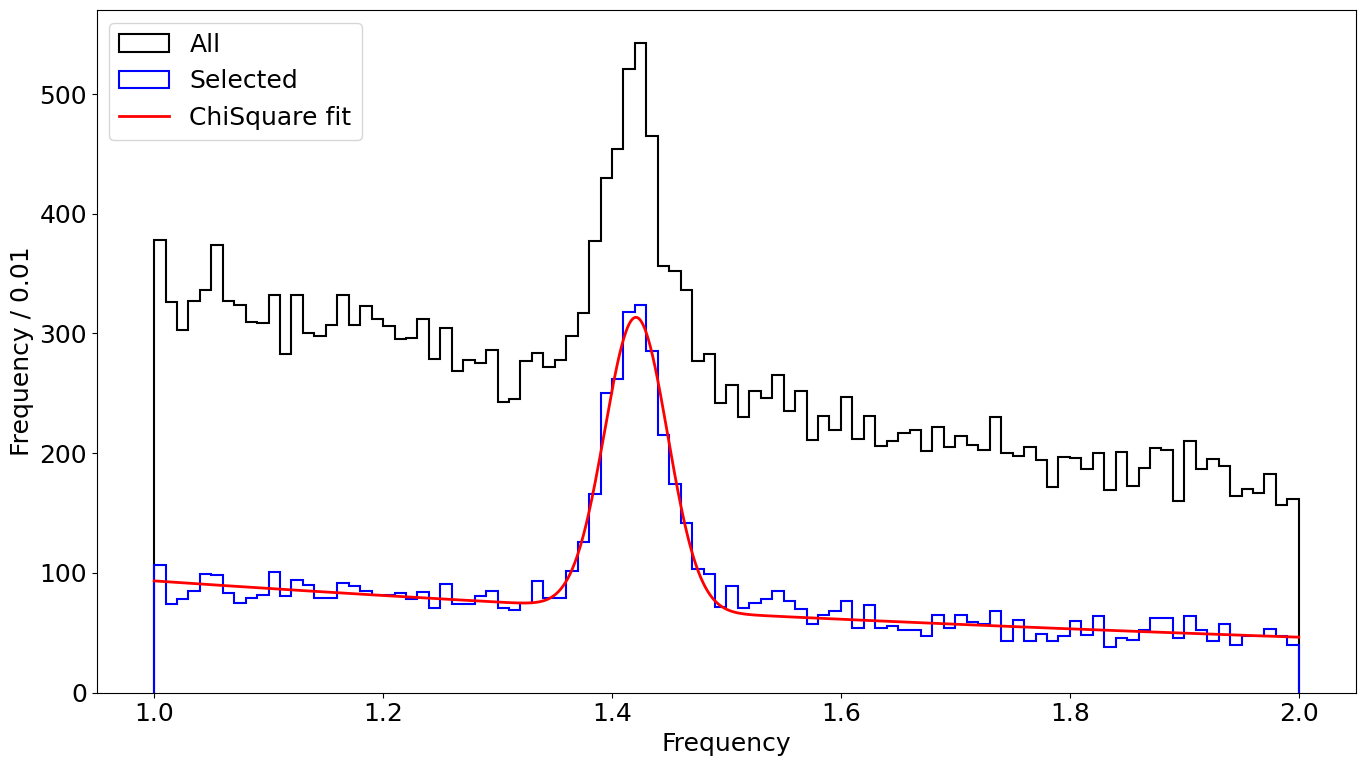

In [22]:
fig_1Dcut, ax_1Dcut = plt.subplots(ncols=1, figsize=(14, 8))

ax_1Dcut.hist(data[:, 3][mask1_selection], 100, (1, 2), histtype='step', label='All', color='Black', lw=1.5)
ax_1Dcut.hist(data[:, 3][mask2_selection], 100, (1, 2), histtype='step', label='Selected', color='Blue', lw=1.5)
ax_1Dcut.set(title='', xlabel='Frequency', ylabel='Frequency / 0.01')

x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_GaussExp(x_fit, *minuit_chi2.values[:])
ax_1Dcut.plot(x_fit, y_fit, '-', color='red', linewidth=2, label='ChiSquare fit')

ax_1Dcut.legend(loc='upper left')
fig_1Dcut.tight_layout()
#fig_1Dcut.savefig('MoleCuleTypes_TestingGaussian2.pdf', dpi=600)

### Consider the TEST sample:

In [23]:
def func_GaussPol2(x, Nsig, mu, sigma, Nbkg, c1, c2) :
    return Nsig * binwidth * stats.norm.pdf(x, mu, sigma) + Nbkg * binwidth * (1.0 + c1*x + c2*x*x)

In [24]:
Nbins = 50
xmin, xmax = 0.0, 1.0
binwidth = (xmax-xmin)/Nbins

mask3_selection = (data[:,4]==-1)
mask4_selection = ((-data[:,1]+data[:,2] > 0.0) & (data[:,4]==-1))

y, bin_edges = np.histogram(data[:, 3][mask4_selection], bins=Nbins, range=(xmin, xmax), density=False)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)

fit_chi2 = cost.LeastSquares( x[y>0], y[y>0], sy[y>0], func_GaussExp)
minuit_chi2 = Minuit(fit_chi2, Nsig=600.0, mu=0.327, sigma=0.025, Nbkg=500, tau=1.0)
minuit_chi2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 42.37 (χ²/ndof = 0.9)      │              Nfcn = 294              │
│ EDM = 3.38e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nsig  │    158    │    26     │            │            │         │         │       │
│ 1 │ mu    │   0.326   │   0.005   │            │            │         │         │       │
│ 2 │ sigma │   0.026   │   0.005   │            │            │         │         │       │
│ 3 │ Nbkg  │  4.86e3   │  0.29e3   │            │            │         │         │       │
│ 4 │ tau   │   1.27    │   0.11    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │       Nsig         mu      sigma       Nbkg        tau │
├───────┼────────────────────────────────────────────────────────┤
│  Nsig │        659  20.714e-3  59.052e-3      0.1e3      0.398 │
│    mu │  20.714e-3   2.44e-05   0.009e-3 -51.162e-3  -0.005e-3 │
│ sigma │  59.052e-3   0.009e-3   2.04e-05  -2.446e-3   0.042e-3 │
│  Nbkg │      0.1e3 -51.162e-3  -2.446e-3   8.57e+04     30.532 │
│   tau │      0.398  -0.005e-3   0.042e-3     30.532     0.0124 │
└───────┴────────────────────────────────────────────────────────┘

In [25]:
for name in minuit_chi2.parameters:
    print("Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_chi2.values[name], minuit_chi2.errors[name]))
    
Ndof = len(y[y>0])-len(minuit_chi2.values[:])
ProbChi2 = stats.chi2.sf(minuit_chi2.fval, Ndof)
print(f"  The fit p-value was: Prob(Chi2={minuit_chi2.fval:5.1f}, Ndof={Ndof:2d}) = {ProbChi2:6.4f}")

Nsignal_significance = minuit_chi2.values[0]/minuit_chi2.errors[0]

print('peak significance was ' + str(Nsignal_significance) + r' $\sigma')
print(157/0.92)

Fit result: Nsig = 157.55583 +/- 25.66605
Fit result: mu = 0.32575 +/- 0.00494
Fit result: sigma = 0.02562 +/- 0.00451
Fit result: Nbkg = 4864.33957 +/- 292.74267
Fit result: tau = 1.26840 +/- 0.11139
  The fit p-value was: Prob(Chi2= 42.4, Ndof=45) = 0.5840
peak significance was 6.138686988516071 $\sigma
170.65217391304347


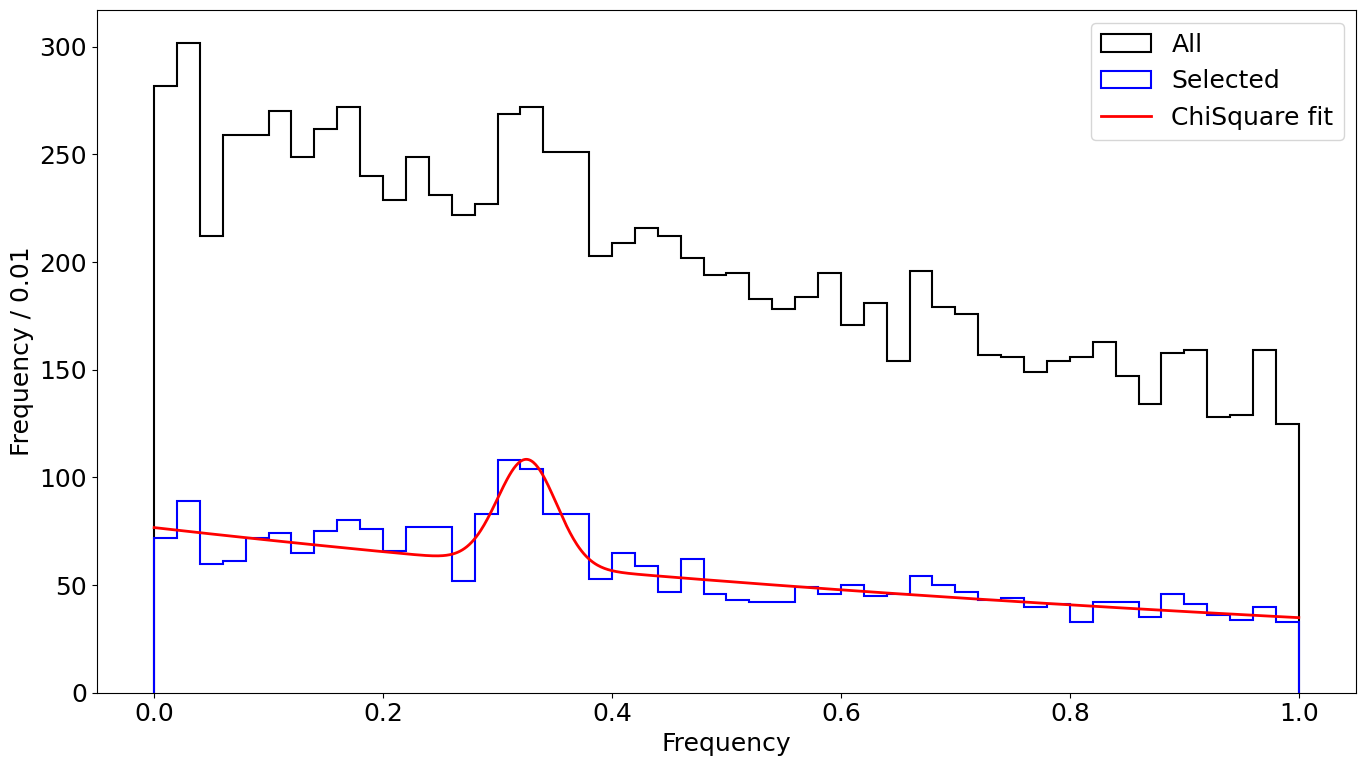

In [26]:
fig_1Dcut, ax_1Dcut = plt.subplots(ncols=1, figsize=(14, 8))

ax_1Dcut.hist(data[:, 3][mask3_selection], Nbins, (xmin, xmax), histtype='step', label='All', color='Black', lw=1.5)
ax_1Dcut.hist(data[:, 3][mask4_selection], Nbins, (xmin, xmax), histtype='step', label='Selected', color='Blue', lw=1.5)
ax_1Dcut.set(title='', xlabel='Frequency', ylabel='Frequency / 0.01')

x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_GaussExp(x_fit, *minuit_chi2.values[:])
ax_1Dcut.plot(x_fit, y_fit, '-', color='red', linewidth=2, label='ChiSquare fit')

ax_1Dcut.legend(loc='upper right')
fig_1Dcut.tight_layout()
#fig_1Dcut.savefig('MoleCuleTypes_TestingGaussian2.pdf', dpi=600)